# EDA
We'll import and perform the bulk of our EDA in this file

Our first step will be to import the neccessary libraries.
Next we'll import the three datasets here, and perform the following tasks:
* Examine the first 5 rows 
* Look for NaN values
* Examine "water_quality" column values in our Labels set

In [1]:
# Imports:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import graphviz 


from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler

from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, accuracy_score


from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Import Data

### Train

In [2]:
# The independent variables for the training set
df_train_values= pd.read_csv('CSVFiles/TrainingSetValues.csv')
# Examine values
df_train_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
# When was the data collected?
print(max(df_train_values['date_recorded']))
print(min(df_train_values['date_recorded']))

2013-12-03
2002-10-14


### Test

We won't need this data to perform our predictive analysis, as it's strictly for contest applicants, but we can take a quick peek to see what it looks like...

In [4]:
# Examine values
df_test_values= pd.read_csv('CSVFiles/TestSetValues.csv')

df_test_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


### Target
Just like our independent variables, we'll check our target for missing values. Additionally we'll look for any class imbalances; Skewness would be a problem because it would negatively affect the accuracy of our model, and would need to be remediated through the use of either resampling or SMOTE.

In [5]:
# The dependent variable (status_group) for each of the rows in Training set values
df_train_labels= pd.read_csv('CSVFiles/TrainingSetLabels.csv')
# Examine labels- everything looks good
df_train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


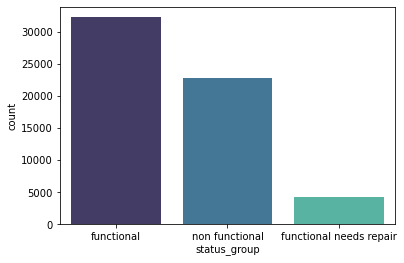

In [6]:
# Check for class imbalances
sns.countplot(x=df_train_labels['status_group'], palette= 'mako');

Clearly there is a class imbalance, with 'functional needs repair' far outweighed by both 'functional' and 'non functional'.  There are several ways we could adress this; by using SMOTE or another resampling technique, by using the appropriate classification metric like precision, recall, f1 score, or AUC.  We will at a minimum use an f1 score for our models, as we can see a breakdown of how well each of the three outcomes perform with our models, and may use SMOTE or another resampling technique depending on our models performance.

### Merge DF's

In [7]:
# Merge training and target dataframes
df= pd.merge(df_train_values, df_train_labels)

## EDA

We'll begin our EDA by looking our target values mapped by lat. and long. to see if there's a geographic pattern to well failure.  Then we'll examinine column values to determine:
* which columns are duplicates and could be dropped
* which will need cleaning due to NaN or erroneous values


### Map of Wells

In [8]:
# Eliminate outlier/erroneous value
df = df[df['longitude']>= 28]

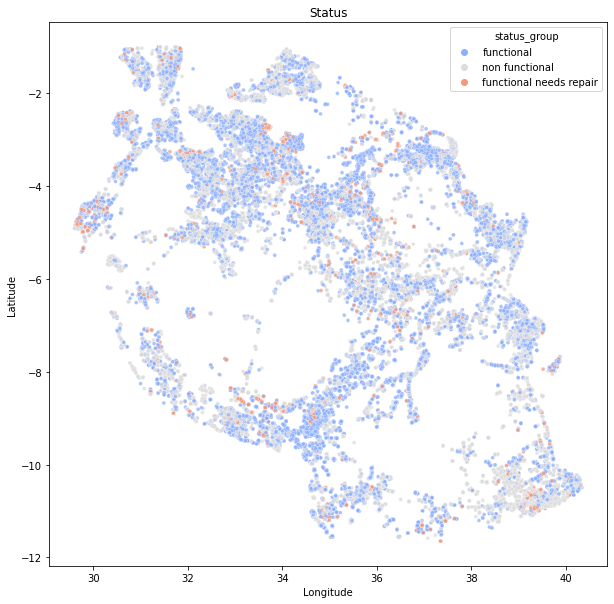

In [9]:
# Examine map of wells


plt.figure(figsize = (10, 10))
sns.scatterplot(x = 'longitude', y = 'latitude',
                hue = 'status_group', data = df, alpha = 0.75, s = 15, palette = 'coolwarm')
plt.title('Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

There's no evident accute geographic distribution for well failure, although we can see great swaths of the country are either without well access, uninhabited, or bodies of water by the large white area.  While well failure seems widely distributed throughout the country it appears there's a higher ratio of non functional wells (grey) to functional wells (blue) in the southeastern tip of the country.  

### Column Values

In [10]:
# Examine Dtype and non-null values
for col in df.columns:
    print(df[col].value_counts(normalize=True), '\n')

2047     0.000017
20959    0.000017
4759     0.000017
661      0.000017
2708     0.000017
           ...   
62836    0.000017
52595    0.000017
50546    0.000017
56689    0.000017
0        0.000017
Name: id, Length: 57588, dtype: float64 

0.0         0.691585
500.0       0.053865
50.0        0.042926
1000.0      0.025839
20.0        0.025405
              ...   
8500.0      0.000017
6300.0      0.000017
220.0       0.000017
138000.0    0.000017
12.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64 

2011-03-15    0.009933
2011-03-17    0.009690
2013-02-03    0.009464
2011-03-14    0.009030
2011-03-16    0.008908
                ...   
2011-09-26    0.000017
2011-09-20    0.000017
2011-09-06    0.000017
2004-06-01    0.000017
2011-09-16    0.000017
Name: date_recorded, Length: 353, dtype: float64 

Government Of Tanzania    0.163844
Danida                    0.057703
Hesawa                    0.035467
World Bank                0.024923
Kkkt                      0.023848
   

There are several problems that jump out immediately in the features.  Many of the columns are duplicate values, or contain information that seems functionally irrelevant for determining the status of a well:


__*date_recorded*__- irrelevant/date the row was entered.

__*id*__- duplicate/using lat/long as unique identifiers

__*funder*__- irrelevant/too many values

__*wpt_name*__- irrelevant/name of well

__*num_private*__- irrelevant/mostly zeros

__*subvillage*__- duplicate location info, 19,000+ entries

__*region*__- duplicate of region_code

__*lga*__- more geographic names

__*ward*__- duplicate of other location data

__*public_meeting*__- outdated info/public pump or private.  

__*recorded_by*__- irrelevant

__*scheme_management*__- irrelevant/out-of-date

__*permit*__- irrelevant/if the waterpoint is permitted

__*extraction_type_group*__ - duplicate of extraction_type

__*extraction_type_class*__ - duplicate of extraction_type

__*management*__ - irrelevant/how the waterpoint is managed (all are now state/locally owned)

__*management_group*__ - duplicate/how the waterpoint is managed

__*payment*__ - irrelevant/what the water costs

__*payment_type*__ - irrelevant/what the water costs

__*quality_group*__ - duplicate of water_quality

__*quantity_group*__ - duplicate of __*quantity*__, also vague and unscientific

__*source_type*__ - duplicate of source_class

__*source*__ - duplicate of source_class

__*waterpoint_type*__ - duplicate of extraction type/kind of waterpoint

__*waterpoint_type_group*__ - duplicate/kind of waterpoint




> *We'll explore the values of the columns we're left with:*

__*amount_tsh*__- TSH measures the distance water travels vertically to the pump site.  70% have 0, indicating the well is actually groundwater/sourced from lakes, streams, rivers, etc.  We also see some values that might be erroneous, like 138,000, but might not be if the water is travelling through piping to a house in a town for instance.  This column may be problematic, but we'll include it in our logistic regression model.

__*installer*__- Too many values, needs cleaning

__*basin*__ - Geographic water basin

__*quality_group*__ Quality_group

__*source_class*__ The source of the water

__*extraction_type*__- The kind of extraction the waterpoint uses

__*gps_height*__- Everything looks fairly normal.  Note that some wells exist below sea level and therefore have negative values

__*population*__  Population around the well

__*construction_year*__- year the waterpoint was constructed

__*latitude*__ and __*longitude*__- could be useful, all cleaning done already

__*district_code*__  Geographic location (coded)




In [11]:
# First edit of column selection
df= df[['amount_tsh', 'latitude', 'installer', 'longitude', 'basin', 'district_code', 'population', 'construction_year', 'gps_height',
                          'quality_group', 'source_class', 'extraction_type', 'status_group']].copy()

# Visually inspect df
df


,amount_tsh,latitude,installer,longitude,basin,district_code,population,construction_year,gps_height,quality_group,source_class,extraction_type,status_group
0,6000.0,-9.856322,Roman,34.938093,Lake Nyasa,5,109,1999,1390,good,groundwater,gravity,functional
1,0.0,-2.147466,GRUMETI,34.698766,Lake Victoria,2,280,2010,1399,good,surface,gravity,functional
2,25.0,-3.821329,World vision,37.460664,Pangani,4,250,2009,686,good,surface,gravity,functional
3,0.0,-11.155298,UNICEF,38.486161,Ruvuma / Southern Coast,63,58,1986,263,good,groundwater,submersible,non functional
4,0.0,-1.825359,Artisan,31.130847,Lake Victoria,1,0,0,0,good,surface,gravity,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,-3.253847,CES,37.169807,Pangani,5,125,1999,1210,good,groundwater,gravity,functional
59396,4700.0,-9.070629,Cefa,35.249991,Rufiji,4,56,1996,1212,good,surface,gravity,functional
59397,0.0,-8.750434,NaN,34.017087,Rufiji,7,0,0,0,fluoride,groundwater,swn 80,functional
59398,0.0,-6.378573,Musa,35.861315,Rufiji,4,0,0,0,good,groundwater,nira/tanira,functional


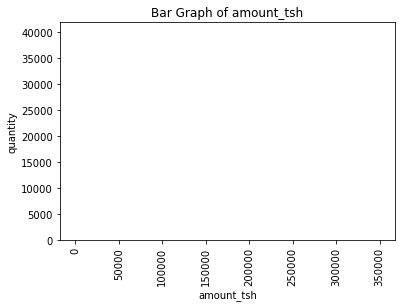

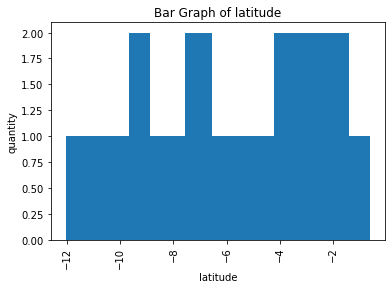

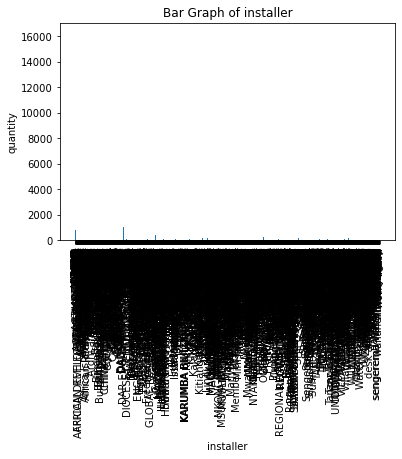

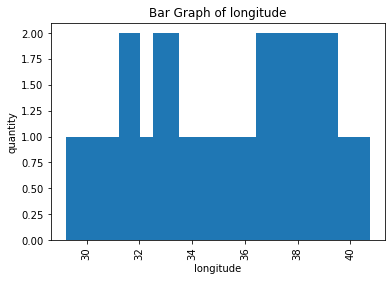

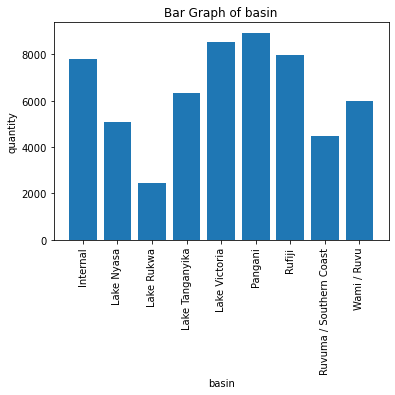

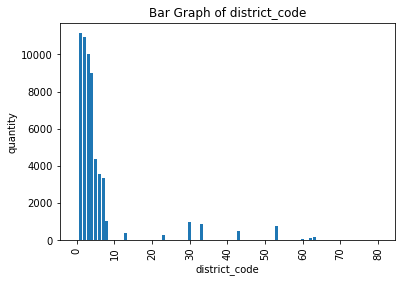

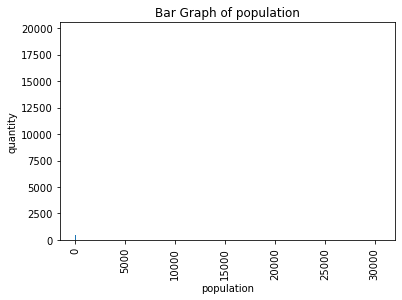

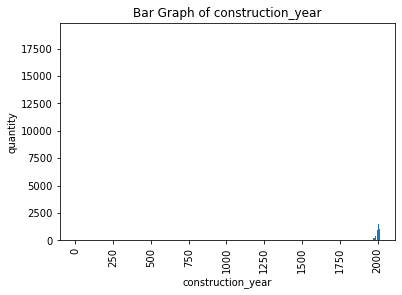

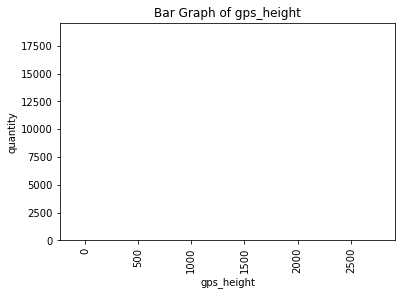

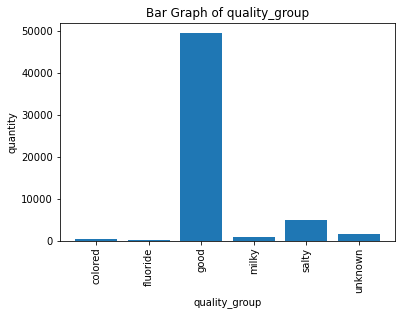

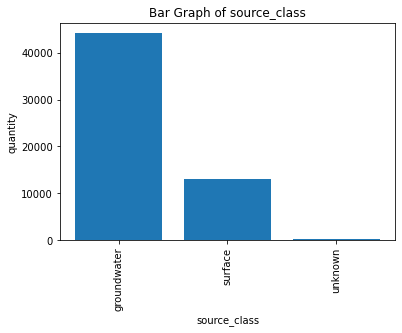

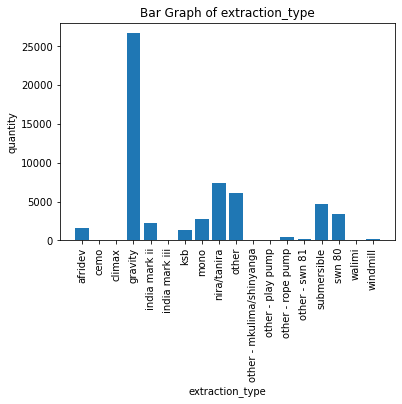

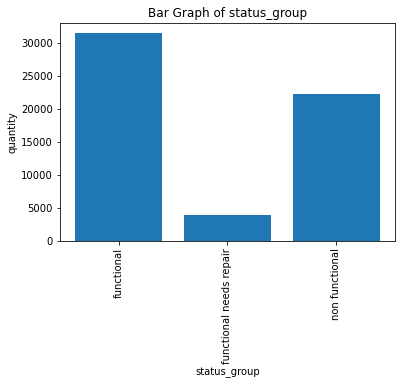

In [14]:
# Iterate over each column in the dataset
for column in df.columns:
    
    # Find values for columns 
    column_values = df[column].value_counts()
    
    # Sort the values by index to ensure proper ordering
    column_values = column_values.sort_index()
    
    # Create the bar graph
    plt.bar(column_values.index, column_values.values)
    
    # Set the title and labels
    plt.title(f'Bar Graph of {column}')
    plt.xlabel(column)
    plt.ylabel('quantity')
    
    # Rotate the x-axis labels by 90 degrees
    plt.xticks(rotation=90)
    
    # Show the bar graph
    plt.show()


What a mess!  Let's begin our exploration by taking a look at what arose when we looked at the plots of our df:
1. __TSH__ remains a mystery, we'll need a closer look

2. There are too many __installers__ for our model, we'll take the top 30 installers and assign the rest to "other"

3.  __Basins__ offers some good insight into the bodies of water that are the primary sources of water for Tanzanians.  We'll dig into which of these 9 are problematic in terms of naturally occuring and manmade pollution

4.  __Quality_group__ can be bianry encoded to good/nonpotable, as salty, floride, colored, milky and unknown are all undesirable qualities for drinking water

5.  Likewise, with __source_class__  we can drop the .4 % of "unknown"s to leave "surface" and "ground" for binary encoding

6. __Extraction_type__ is slightly confusing, with the manufacturer names for pumps interspersed with things like "other- play pump".  We will clean this by assigning some of these misc. categories to "other" and OHEing.

#### TSH

From the value counts we printed earlier it was clear that TSH could be a valuable aid in identifying points from which Tanzanians are drawing water directly from ground sources, such as lakes, rivers and streams.  TSH refers to the total distance the water must travel before reaching it's output (a pumphead, faucet, etc).  TSH recorded as 0 indicates the water source is being drawn from directly.  What's more concerning would be TSH readings with extra high values (like our max of 350,000), indicating a possibly erroneous entry.  To put that in context, if our entries are in meters, that means water is being pumped 217 miles, in a country that is 760 miles across it's largest stretch.  It's highly likely that these values are wrong.  We'll poke around to ensure our theory is correct and replace any nonesense values with the mean TSH if needed.

In [12]:
# Investigate TSH
df.amount_tsh.describe()

count     57588.000000
mean        327.645219
std        3043.831403
min           0.000000
25%           0.000000
50%           0.000000
75%          30.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [16]:
# Count the status of water wells with amount_tsh of zero to make sure our assumptions are correct
count = df[(df["amount_tsh"] == 0) & (df["status_group"] == "non functional")].shape[0]
count2 = df[(df["amount_tsh"] == 0) & (df["status_group"] == "functional")].shape[0]
count3 = df[(df["amount_tsh"] == 0) & (df["status_group"] == "functional needs repair")].shape[0]

# Print
print("Number of water wells with amount_tsh of zero and not functional:", count)
print("Number of water wells with amount_tsh of zero and functional:", count2)
print("Number of water wells with amount_tsh of zero and functional/need repair:", count3)


Number of water wells with amount_tsh of zero and not functional: 18329
Number of water wells with amount_tsh of zero and functional: 18836
Number of water wells with amount_tsh of zero and functional/need repair: 2662


In [17]:
# How many wells are pumping water over 2.5ish miles
two_mile= df.loc[df.amount_tsh >=5000]
len(two_mile)

920

Because it's entirely possible that water is being pumped over great distances, we'll only replace the top 1% of entries with our mean.  The max is still 5000 meters, about 2.5 miles.  Then we'll group TSH by 100's, to further lower the number unique values to aid in establishing if there is a pattern between TSH values and well failure.

In [13]:
# Calculate the mean value of the "amount_tsh" column
mean_amount_tsh = df["amount_tsh"].mean()

# Calculate the threshold value for the top 1% values
threshold = np.percentile(df["amount_tsh"], 99)

# Replace the top 1% values with the mean value
df.loc[df["amount_tsh"] > threshold, "amount_tsh"] = mean_amount_tsh

# Group 'amount_tsh' values by 100's
df['tsh_group'] = pd.cut(df['amount_tsh'], bins=np.arange(0, 5100, 100), right=False)


In [14]:
# Here we can see our unique values have dropped to 24 
#from the thousands of unique values we had when we started
df.tsh_group.describe()   

count        57138
unique          26
top       [0, 100)
freq         46467
Name: tsh_group, dtype: object

In [15]:
# Examine the frequency at which our data appears
pd.crosstab(df['tsh_group'], df['status_group'], normalize = 'index')


status_group,functional,functional needs repair,non functional
tsh_group,,,
"[0, 100)",0.506876,0.062862,0.430262
"[100, 200)",0.673835,0.071685,0.254480
"[200, 300)",0.610056,0.153073,0.236872
"[300, 400)",0.729389,0.073715,0.196896
"[400, 500)",0.797619,0.000000,0.202381
"[500, 600)",0.716951,0.088131,0.194918
"[600, 700)",0.375000,0.409091,0.215909
"[700, 800)",0.493976,0.156627,0.349398
"[800, 900)",1.000000,0.000000,0.000000


Even without digging in deeper we can see that there is no immediately apparent pattern to TSH and well functionality.  Some of our values indicate that there's only a few wells falling into any one of our 3 categories, but not the others (like 2200-2300, which has 100% functioning wells).  It's possible that dropping this column will improve our models performance.

#### Installer

In [31]:
# Examine values 
df['installer'].value_counts().head(10)

DWE                   16255
Government             1670
RWE                    1181
Commu                  1060
DANIDA                 1050
KKKT                    897
Hesawa                  803
0                       777
TCRS                    707
Central government      619
Name: installer, dtype: int64

In [32]:
# Look at nos. of unnique values and count (check for NaN)
df['installer'].describe()

count     53952
unique     2113
top         DWE
freq      16255
Name: installer, dtype: object

In [16]:
# Replace zero's in df (NaN values) with "other"
df['installer'].replace('0', 'other', inplace = True)

In [17]:
# Find and make list of top 30 installers
top_30= df.installer.value_counts(normalize = True).head(30)
top_30.head()


DWE           0.301286
Government    0.030953
RWE           0.021890
Commu         0.019647
DANIDA        0.019462
Name: installer, dtype: float64

In [18]:
# Function to replace anything not in top_30 with "other"
def replace(column):
    return column.apply(lambda x: x if x in top_30 else 'other')

# Replace values in df
df['installer'] = replace(df['installer'])

In [19]:
# Check- "other" should now be the top of the list
df['installer'].value_counts().head()

other         25704
DWE           16255
Government     1670
RWE            1181
Commu          1060
Name: installer, dtype: int64

In [38]:
# Examine the frequency at which our data appears
pd.crosstab(df['installer'], df['status_group'], normalize = 'index')

status_group,functional,functional needs repair,non functional
installer,,,
ACRA,0.978417,0.000000,0.021583
AMREF,0.474164,0.018237,0.507599
CES,0.881967,0.001639,0.116393
Central government,0.266559,0.006462,0.726979
Commu,0.683019,0.030189,0.286792
Community,0.701299,0.074212,0.224490
DANID,0.780797,0.016304,0.202899
DANIDA,0.516190,0.079048,0.404762
DW,0.500000,0.004065,0.495935


Installer clearly has an impact on the target variable.  This one's a keeper.

#### Basin

In [39]:
# Investivate "basin"
df.basin.describe()

count       57588
unique          9
top       Pangani
freq         8940
Name: basin, dtype: object

In [41]:
# Examine the frequency at which our data appears
pd.crosstab(df['basin'], df['status_group'], normalize = 'index')

status_group,functional,functional needs repair,non functional
basin,,,
Internal,0.575723,0.071548,0.352730
Lake Nyasa,0.653687,0.049164,0.297148
Lake Rukwa,0.407498,0.110024,0.482478
Lake Tanganyika,0.480973,0.116532,0.402495
Lake Victoria,0.502753,0.071119,0.426128
Pangani,0.600895,0.053356,0.345749
Rufiji,0.635406,0.054789,0.309804
Ruvuma / Southern Coast,0.371689,0.072557,0.555753
Wami / Ruvu,0.523802,0.044931,0.431268


We can see a clear relationship between certain basins and well functionality, particularly in the Southern Coast, where well functinality is at it's lowest.

#### Quality Group

In [52]:
# Examine values
df.quality_group.describe()

count     57588
unique        6
top        good
freq      49431
Name: quality_group, dtype: object

In [20]:
# Replace all categories but "good" with "bad"
    # Define the categories to be replaced with "bad"
bad_quality = ['colored', 'fluoride', 'salty', 'milky', 'unknown']

    # Replace the categories with "bad"
df['quality_group'] = df['quality_group'].replace(bad_quality, 'bad')

# Inspect
df.quality_group.value_counts()

good    49431
bad      8157
Name: quality_group, dtype: int64

In [21]:
# Examine the frequency at which our data appears
pd.crosstab(df['quality_group'], df['status_group'], normalize = 'index')

status_group,functional,functional needs repair,non functional
quality_group,,,
bad,0.417555,0.039966,0.542479
good,0.566102,0.072930,0.360968


It is important to note that __41% of the functioning wells are pumping water that is non-potable__

In [55]:
functional_df = df[df["status_group"] == "functional"]


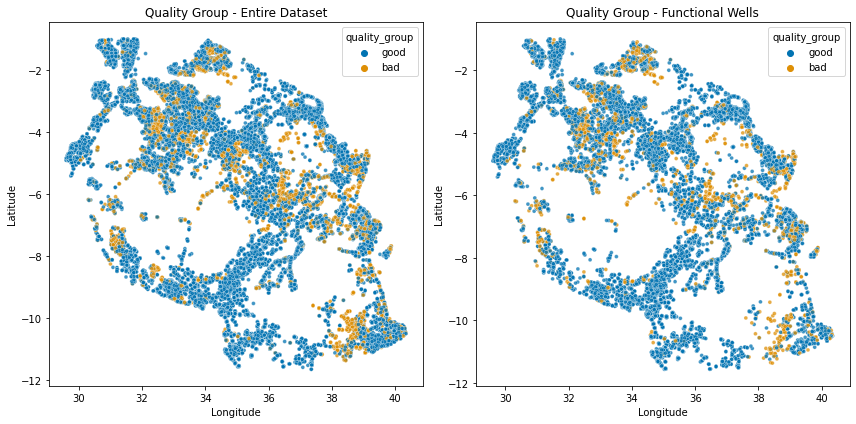

In [56]:
# Create subplots with one row and two columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for quality_group in the entire dataset
sns.scatterplot(ax=axes[0], x='longitude', y='latitude', hue='quality_group',
                data=df, alpha=0.75, s=15, palette='colorblind')
axes[0].set_title('Quality Group - Entire Dataset')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Scatter plot for quality_group in the functional_df subset
sns.scatterplot(ax=axes[1], x='longitude', y='latitude', hue='quality_group',
                data=functional_df, alpha=0.75, s=15, palette='colorblind')
axes[1].set_title('Quality Group - Functional Wells')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# Adjust the layout and spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()



We can see a thinning of wells throughout the country when we filter out the non-functional and functional needs repair categories, particularly along the southeast coast, an area we have noted for it's lack of water access before. 

#### Source Class

In [57]:
# Quick refresher on the values, some imbalances to note:
df.source_class.value_counts()

groundwater    44204
surface        13118
unknown          266
Name: source_class, dtype: int64

In [58]:
df.source_class.describe()

count           57588
unique              3
top       groundwater
freq            44204
Name: source_class, dtype: object

In [59]:
# Examine the frequency at which our data appears
pd.crosstab(df['source_class'], [df['status_group'], df['quality_group']])

status_group  functional        functional needs repair       non functional  \
quality_group        bad   good                     bad  good            bad   
source_class                                                                   
groundwater         3147  20895                     276  2098           4111   
surface              180   7009                      49  1503            267   
unknown               79     79                       1     4             47   

status_group          
quality_group   good  
source_class          
groundwater    13677  
surface         4110  
unknown           56

There's about four times more groundwater (water from aquafers) than surfacewater(water from lakes, streams, and rivers).  

#### Extraction Type

This is a list of the type of well pump that installed at each site.  Some are gas or electric motors, others, like windmill or rope pumps, are simple machines  Because we saw several "other" catergories we'll group all "other-'plus info" in with "other".

In [22]:
df.extraction_type.describe()

count       57588
unique         18
top       gravity
freq        26696
Name: extraction_type, dtype: object

In [23]:
# Quick refresher on the values
df.extraction_type.value_counts()

gravity                      26696
nira/tanira                   7361
other                         6160
submersible                   4688
swn 80                        3448
mono                          2817
india mark ii                 2284
afridev                       1659
ksb                           1358
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  91
cemo                            90
other - play pump               85
climax                          32
walimi                          20
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [24]:
# Replace all categories "other-..." categories with "other"
    # Define the categories to be replaced with "other"
bad_extype = ['other - play pump', 'other - mkulima/shinyanga', 'other - swn 81',
            'other - rope pump']

    # Replace the categories with "bad"
df['extraction_type'] = df['extraction_type'].replace(bad_extype, 'other')

# Inspect
df.extraction_type.value_counts()

gravity           26696
nira/tanira        7361
other              6927
submersible        4688
swn 80             3448
mono               2817
india mark ii      2284
afridev            1659
ksb                1358
windmill            117
india mark iii       91
cemo                 90
climax               32
walimi               20
Name: extraction_type, dtype: int64

In [25]:
# Examine the frequency at which our data appears
pd.crosstab(df['extraction_type'], df['status_group'], normalize = 'index')

status_group,functional,functional needs repair,non functional
extraction_type,,,
afridev,0.670283,0.022303,0.307414
cemo,0.500000,0.100000,0.400000
climax,0.250000,0.000000,0.750000
gravity,0.600165,0.100727,0.299108
india mark ii,0.594133,0.028021,0.377846
india mark iii,0.450549,0.010989,0.538462
ksb,0.516937,0.019146,0.463918
mono,0.376997,0.045793,0.577210
nira/tanira,0.671240,0.053797,0.274963


It's obvious some methods/well pump models are more reliable than others, like 'gravity' and 'nira' vs 'other', but most methods are roughly 40-50% functional.

#### GPS Height
From previous value_counts we know that some of the heights are negative, indicating  they are below sea level.  There's 9 countries in Africa that have land below sea level, but Tanzania is not one of them, we clearly have bad data. The most likely scenario is that the negative values are accidental, and we can just drop the - sign for the true gps height.

In [26]:
# Reminder of values
df.gps_height.value_counts().head()

 0     18626
-15       60
-16       55
-13       55
-20       52
Name: gps_height, dtype: int64

In [27]:
# Drop negative sign 
df['gps_height']= df['gps_height'].abs()

# Check values
df['gps_height'].head()

0    1390
1    1399
2     686
3     263
4       0
Name: gps_height, dtype: int64

#### Population
Although that's a large number of wells that have a population of zero, it's not unimaginable to have a large number of well sites situated some distance from the towns and cities they serve.  Population looks to need no cleaning.  

In [28]:
# Population min and max
df.population.describe()

count    57588.000000
mean       185.570831
std        477.744239
min          0.000000
25%          0.000000
50%         35.000000
75%        230.000000
max      30500.000000
Name: population, dtype: float64

In [29]:
pop_zero= df.loc[df.population==0]
len(pop_zero)

19569

#### Construction Year
There are some values of zero in here, which will certainly need to be replaced...

In [30]:
# year min and max
df.construction_year.describe()

count    57588.000000
mean      1341.577360
std        937.641368
min          0.000000
25%          0.000000
50%       1988.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

In [31]:
# How many are built in year 0?

len(df.loc[df.construction_year==0])

18897

Almost a third of our values in this column are zero, but over 1/2 of those wells are functional.  Although there are some outliers, most wells with that rate of functionality were built after 1994.  Nonetheless, year built is a categorical not numeric quality, and so we'll group years by decade to make it easier to OHE this data.

In [32]:
# Convert "construction_year" column to numeric
df["construction_year"] = pd.to_numeric(df["construction_year"], errors="coerce")

# Create a new column "decade_built" and initialize it as "unknown"
df["decade_built"] = "unknown"

# Map the decade values based on the "construction_year" column
df.loc[df["construction_year"] == 0, "decade_built"] = "unknown"
df.loc[(df["construction_year"] >= 1960) & (df["construction_year"] < 1970), "decade_built"] = "1960"
df.loc[(df["construction_year"] >= 1970) & (df["construction_year"] < 1980), "decade_built"] = "1970"
df.loc[(df["construction_year"] >= 1980) & (df["construction_year"] < 1990), "decade_built"] = "1980"
df.loc[(df["construction_year"] >= 1990) & (df["construction_year"] < 2000), "decade_built"] = "1990"
df.loc[(df["construction_year"] >= 2000) & (df["construction_year"] < 2010), "decade_built"] = "2000"
df.loc[df["construction_year"] >= 2010, "decade_built"] = "2010"

# Verify the new column
df["decade_built"].value_counts()

unknown    18897
2000       15330
1990        7678
1980        5578
2010        5161
1970        4406
1960         538
Name: decade_built, dtype: int64

In [33]:
# Drop 'construction_year' from df
df.drop('construction_year', axis=1, inplace=True)

In [34]:
# Examine the frequency at which our data appears
pd.crosstab(df['decade_built'], df['status_group'], normalize = 'index')

status_group,functional,functional needs repair,non functional
decade_built,,,
1960,0.289963,0.078067,0.631970
1970,0.319110,0.078983,0.601906
1980,0.397992,0.075834,0.526174
1990,0.539073,0.067465,0.393462
2000,0.651598,0.063731,0.284671
2010,0.735129,0.042627,0.222244
unknown,0.512515,0.074245,0.413240


#### District Code

In [35]:
# Examine values
df.district_code.describe()

count    57588.000000
mean         5.728311
std          9.760254
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         80.000000
Name: district_code, dtype: float64

In [36]:
# Examine the frequency at which our data appears
pd.crosstab(df['district_code'], df['status_group'], normalize = 'index')

status_group,functional,functional needs repair,non functional
district_code,,,
0,0.173913,0.086957,0.739130
1,0.540642,0.084515,0.374843
2,0.562196,0.075167,0.362636
3,0.495499,0.069914,0.434587
4,0.621721,0.056581,0.321699
5,0.569100,0.044536,0.386364
6,0.498885,0.059955,0.441160
7,0.602453,0.064014,0.333533
8,0.564717,0.050815,0.384468


Let's take a closer look at the population numbers of each district along side  the lowest percentage of plot of operational wells by district

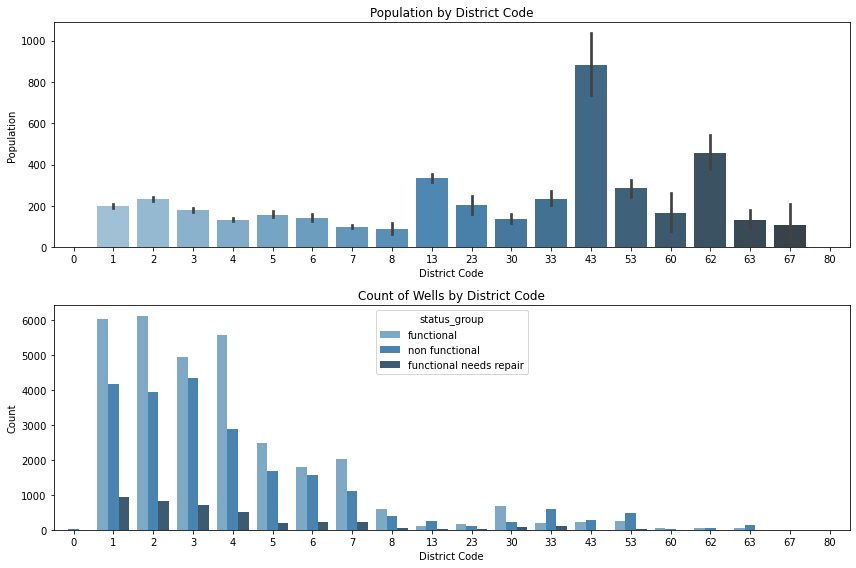

In [37]:
# Plotting the population and status_group for each district_code
plt.figure(figsize=(12, 8))

# Bar plot for population by district_code
plt.subplot(2, 1, 1)
sns.barplot(data=df, x="district_code", y="population", palette="Blues_d")
plt.xlabel("District Code")
plt.ylabel("Population")
plt.title("Population by District Code")

# Count plot for status_group by district_code
plt.subplot(2, 1, 2)
sns.countplot(data=df, x="district_code", hue="status_group", palette="Blues_d" )
plt.xlabel("District Code")
plt.ylabel("Count")
plt.title("Count of Wells by District Code")

plt.tight_layout()
plt.show()


Some of the districts with the largest populations are also those with the fewest wells, operational or otherwise (43, 62).  Similarly, some of the districts with the highest number of functioning wells have lower population figures (1-4).  

# Summary Analysis



1. __*amount_tsh*__ Replaced the top 1% values with the mean value.  Values now range from 0 to 5000

2. __*installer*__ Reduced to top 29 installers plus 'other'

3. __*basin*__  Crosstab confirmed scarcity of water in southeast

4. __*quality_group*__ Reduced to good and bad from milky, salty, lithium, and good

5. __*source_class*__ The source of the water

6. __*extraction_type*__ Aggregated all other+description to just other

7. __*gps_height*__ Replaced negative values with positive counterpoints
 
8. __*population*__  No changes needed

9. __*construction_year*__- altered to __decade_buit__ for easier OHE, wells built after 1994 more likely to be functionsl

10. & 11. __*latitude*__ and __*longitude*__- Map revealed scarcity of water in southeast 

12. __*district_code*__  Possibly revealed areas of concern when examining pop. per district along with number of functional wells.


# Models

We're going to go quickly through this part, performing the neccessary encoding, calling and fitting our models, and finally printing the weighted f1 score to account for our class imbalance.  Our goal is merely to get a quick feel for how our initial models perform.  We'll be building on these in the other 1/2 of this notebook, the 'Phase3_Project' file.

In [38]:
# Break up train test groups
X= df.drop('status_group', axis=1)
y= df['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=18 )

In [39]:
X_train_categorical= X_train[['installer', 'basin', 'quality_group', 'source_class', 'extraction_type','decade_built', 'district_code']].copy()


In [40]:
# OHE categorical data
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe.fit(X_train_categorical)
X_train_ohe = pd.DataFrame(
    ohe.transform(X_train_categorical),
    # index is important to ensure we can concatenate with other columns
    index=X_train_categorical.index,
    # we are dummying multiple columns at once, so stack the names
    columns=np.hstack(ohe.categories_)
)
X_train_ohe

,ACRA,AMREF,CES,Central government,Commu,Community,DANID,DANIDA,DW,DWE,...,23,30,33,43,53,60,62,63,67,80
12632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Break out numeric data
X_train_numeric = X_train[['amount_tsh', 'latitude', 'longitude', 'district_code',
                    'population', 'gps_height']].copy()

In [42]:
# Scale 
scaler = MinMaxScaler()

scaler.fit(X_train_numeric)
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_numeric),
    # index is important to ensure we can concatenate with other columns
    index=X_train_numeric.index,
    columns=X_train_numeric.columns
)
X_train_scaled

,amount_tsh,latitude,longitude,district_code,population,gps_height
12632,0.004,0.778860,0.717913,0.0750,0.000492,0.331050
27434,0.100,0.051051,0.471056,0.0375,0.003213,0.185693
1490,0.002,0.457009,0.703286,0.0125,0.008197,0.167047
58158,0.100,0.905160,0.404701,0.0500,0.013115,0.498858
51941,0.000,0.254836,0.366444,0.0250,0.000000,0.000000
...,...,...,...,...,...,...
50615,0.000,0.603153,0.246652,0.0500,0.000000,0.000000
1784,0.000,0.931696,0.121697,0.0125,0.000000,0.000000
36758,0.000,0.633089,0.825657,0.0125,0.000033,0.465373
26525,0.000,0.433816,0.903754,0.5375,0.034131,0.012557


In [43]:
# Merge dfs
X_train_full = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_train_full

,amount_tsh,latitude,longitude,district_code,population,gps_height,ACRA,AMREF,CES,Central government,...,23,30,33,43,53,60,62,63,67,80
12632,0.004,0.778860,0.717913,0.0750,0.000492,0.331050,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27434,0.100,0.051051,0.471056,0.0375,0.003213,0.185693,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1490,0.002,0.457009,0.703286,0.0125,0.008197,0.167047,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58158,0.100,0.905160,0.404701,0.0500,0.013115,0.498858,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51941,0.000,0.254836,0.366444,0.0250,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50615,0.000,0.603153,0.246652,0.0500,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1784,0.000,0.931696,0.121697,0.0125,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36758,0.000,0.633089,0.825657,0.0125,0.000033,0.465373,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26525,0.000,0.433816,0.903754,0.5375,0.034131,0.012557,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Multinomial Logistic Regression

Because we have three predictors we can skip LabelEcoding our target variable for now, and look at the accuracy and weighted f1 scores (to take into account our class imbalance).   

In [44]:
# Define the range of C values to test
c_values = [10, 100, 1000]

# Create an empty list to store the cross-validation scores for each value of C
cv_scores = []

# Loop over the different values of C and fit a LogisticRegression model for each value
for c in c_values:
    # Create a LogisticRegression object with the current value of C
    lr = LogisticRegression(C=c, max_iter=100, solver='liblinear')
    
    # Use cross-validation to evaluate the performance of the model with the current value of C
    scores = cross_val_score(lr, X_train_full, y_train, cv=5, scoring='accuracy')
    
    # Store the mean cross-validation score for the current value of C
    cv_scores.append(scores.mean())

# Find the value of C with the highest cross-validation score
best_c = c_values[cv_scores.index(max(cv_scores))]

# Print the best value of C
print("Best C:", best_c)

Best C: 100


In [45]:
# Call and fit LogReg
logreg = LogisticRegression(fit_intercept=False, C=100, solver='liblinear', random_state=18)
model_log = logreg.fit(X_train_full, y_train)
model_log

LogisticRegression(C=100, fit_intercept=False, random_state=18,
                   solver='liblinear')

In [46]:
# Check performance on train
y_pred = logreg.predict(X_train_full)
accuracy = accuracy_score(y_train, y_pred)

accuracy


0.6638651570929128

In [47]:
# See f1 
f1 = f1_score(y_train, y_pred, average='weighted')

print(f1)

0.6335157928719766


## Decision Tree

In [48]:
# Call and fit a DT classifier

dtc = DecisionTreeClassifier(random_state=18, max_depth=5, splitter='best')  
dtc.fit(X_train_full, y_train)

DecisionTreeClassifier(max_depth=5, random_state=18)

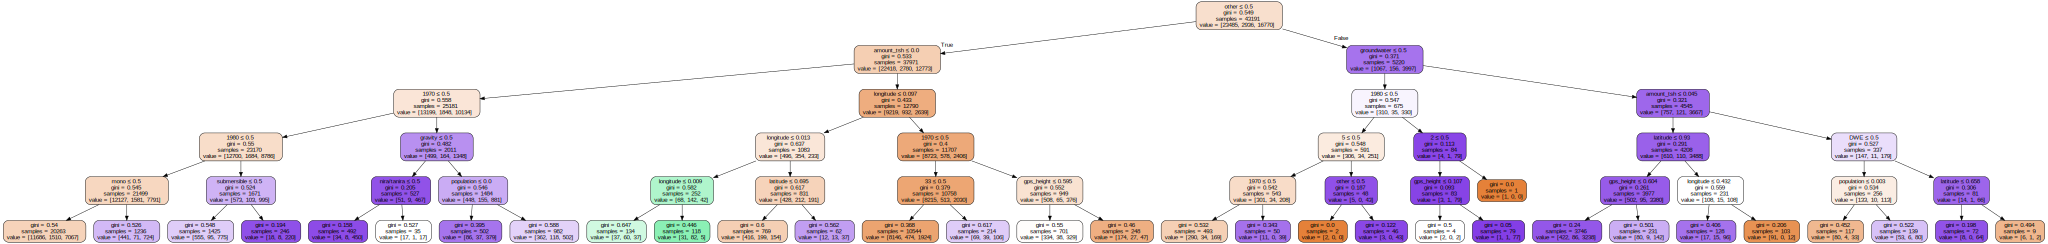

In [49]:
# Plot tree
dot_data = tree.export_graphviz(dtc, out_file=None, 
                      feature_names=X_train_full.columns,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

It would be much more helpful to see the labels with this plot.  We'll do this below with a plotviz.

In [50]:
# Check f1 score
y_hat_train = dtc.predict(X_train_full)
f1 = f1_score(y_train, y_hat_train, average='weighted')

print(f1)

0.6179243050177614


Now that we've completed cleaning and looking at our rough model f1 scores, we can take this information over into the Phase 3 Project file of this notebook and dig in deeper.  Well be looking at ways to improve our model performance:  the f1 scores for our preliminary models was ok, but not very impressive.  We definitely want to improve upon the roughly 60% that we are starting our with here.  We'll also was to take a closer look at our decision tree using labelviz to see which labels were used as splitting points from our intitial node, as that may tell us something about which factors are most relevant to well failure.